In [553]:
import croissant as cro

from astropy.units import K as Kelvin, s as seconds
import healpy
from lunarsky import Time
import matplotlib.pyplot as plt
import numpy as np

In spherical coordinates, where $\theta$ is the polar angle, the power of a dipole antenna is given by:
$$P(\theta, \nu) \propto (L\nu)^2 \cos^2{\theta} $$

In [554]:
# 1 deg spacing, must be radians
theta = np.linspace(0, np.pi, num=181)
theta.shape = (1, -1, 1)
phi = np.linspace(0, 2 * np.pi, num=360, endpoint=False)
phi.shape = (1, 1, -1)
# 1 MHz resolution frequency
freq = np.linspace(1, 50, num=50)
freq.shape = (-1, 1, 1)
# dipole beam
power = freq**2 * np.cos(theta)**2
power = np.repeat(power, phi.size, axis=-1)
power = np.ones_like(power)

In [555]:
beam = cro.beam.Beam(power, theta=theta, phi=phi, frequencies=freq, coords="topocentric")

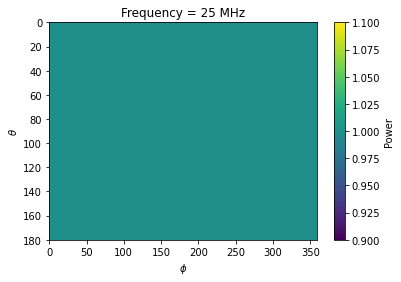

In [556]:
plot_freq = 25  # MHz
freq_ix = np.argmin(np.abs(beam.frequencies-plot_freq))
ex = [beam.phi.min(), beam.phi.max(), beam.theta.max(), beam.theta.min()]
ex_deg = [np.rad2deg(bd) for bd in ex]
plt.figure()
plt.imshow(beam.data[freq_ix], aspect="auto", extent=ex_deg)
plt.colorbar(label="Power")
plt.title(f"Frequency = {beam.frequencies[freq_ix]:.0f} MHz")
plt.xlabel("$\\phi$")
plt.ylabel("$\\theta$")
plt.show()

We use the Global Sky Model (Zheng et al 2016) at 25 MHz as the sky model and extrpolate it by a power law to other frequencies. It has a built-in interface in the sky module of croissant.

In [557]:
sky = cro.sky.Sky.gsm(beam.frequencies, power_law=True, gen_freq=25, spectral_index=-2.5)

In [558]:
lmax = 32
loc = (37.87, 122.27, 0)
t_start = Time("2022-06-01 23:09:16")
t_end = t_start + cro.constants.sidereal_day_earth * seconds
horizon = np.ones_like(beam.data)
sim = cro.simulator.Simulator(
    beam, sky, obs_loc=loc, t_start=t_start, N_times=300, t_end=t_end, moon=False, lmax=lmax, horizon=None
)

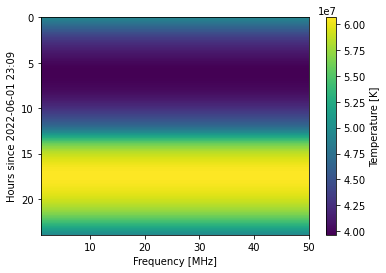

In [559]:
sim.run(dpss=False)
sim.plot(power=2.5)

In [642]:
from pyuvsim import simsetup
t_arr = sim.t_start + sim.dt * seconds
uvd = simsetup.initialize_uvdata_from_keywords(
    array_layout={0: [0,0,0]},
    telescope_location=loc,
    telescope_name="croissant",
    freq_array=sim.frequencies*1e6,
    time_array=t_arr.to_value("jd"),
    bls=[(0,0)],
    complete=True,
    write_files=False,
)

Cannot check consistency of a string-mode BeamList! Set force=True to force consistency checking.


In [643]:
# sky model
from pyradiosky import SkyModel

hpx_inds = np.arange(sky.npix)
stokes = np.zeros((4, 1, npix)) * Kelvin
stokes[0, :, :] = healpy.Rotator(coord="gc").rotate_map_alms(sky.data[0]) * Kelvin  # in equatorial

diffuse_params = {
    'component_type': "healpix",
    'nside': sky.nside,
    'hpx_inds': hpx_inds,
    'hpx_order': "ring",
    'spectral_type': "spectral_index",
    'reference_frequency': np.full(sky.npix, sim.frequencies[0]),
    'spectral_index': np.full(sky.npix, -2.5),
    'stokes': stokes,
    'frame': "icrs"
}
diffuse_model = SkyModel(**diffuse_params)

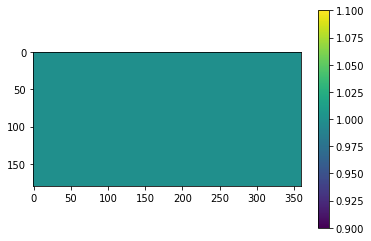

In [644]:
# beam
from pyuvsim import AnalyticBeam
uniform_beam = AnalyticBeam("uniform")


p, t = [x.ravel() for x in np.meshgrid(sim.beam.phi, sim.beam.theta)]
ab_data = uniform_beam.interp(p, t, sim.frequencies*1e6)[0][1, 0, 0]
#ab_data = uniform_beam.interp(p, t, sim.frequencies*1e6)[0][0, 0, 1]
ab_data.shape = (-1, sim.beam.theta.size, sim.beam.phi.size)

plt.figure()
plt.imshow(ab_data[0])
plt.colorbar()
plt.show()

# VisCPU

In [645]:
from copy import deepcopy
from hera_sim.visibilities import ModelData
data_model = ModelData(
    uvdata=deepcopy(uvd),
    sky_model=deepcopy(diffuse_model),
    beam_ids=[0],
    beams=[deepcopy(uniform_beam)],
    normalize_beams=False,
)

In [612]:
from hera_sim.visibilities import VisCPU, VisibilitySimulation

vis_class = VisCPU(use_pixel_beams=False, precision=1, ref_time=t_mid, correct_source_positions=True)
vis_cpu = VisibilitySimulation(deepcopy(data_model), vis_class, sky.nside)
_ = vis_cpu.simulate()

In [613]:
jy2k = sky.data[:, 0] / vis_cpu.data_model.sky_model.stokes[0, :, 0].value  # jansky to K conversion
vis_wfall = vis_cpu.data_model.uvdata.get_data((0, 0, "xx")).real.copy()
vis_wfall *= jy2k  # jy to K
vis_wfall *= 2  # 2 pols
vis_wfall *= 4*np.pi / sky.npix  # pixel normalization
vis_wfall /= sim.beam.total_power  # beam normalization

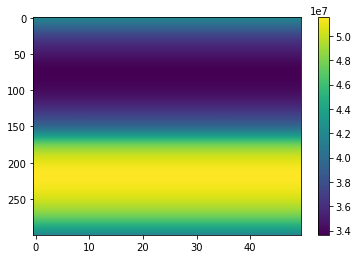

In [614]:
plt.figure()
plt.imshow(vis_wfall * sim.frequencies**2.5, aspect="auto")
plt.colorbar()
plt.show()

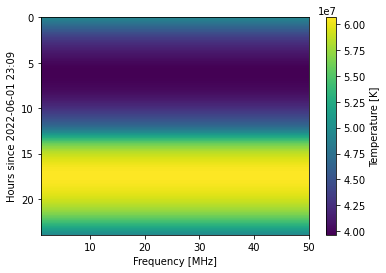

In [615]:
sim.plot(power=2.5)

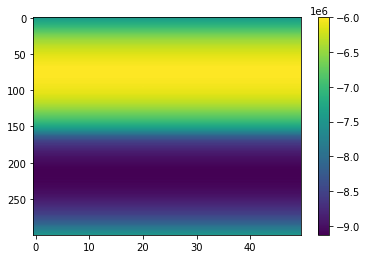

In [616]:
plt.figure()
plt.imshow((vis_wfall - sim.waterfall) * sim.frequencies**2.5, aspect="auto")
plt.colorbar()
plt.show()

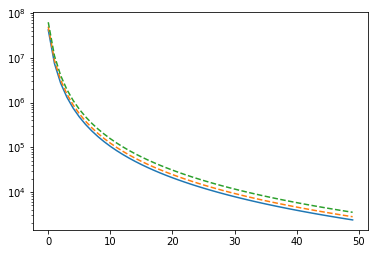

In [617]:
plt.figure()
plt.plot(vis_wfall[0])
plt.plot(sim.waterfall[0], ls="--")
plt.plot(sky.data[:, 0], ls="--")
plt.yscale("log")
plt.show()

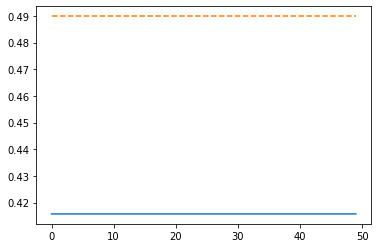

In [618]:
plt.figure()
plt.plot(vis_wfall[0] / sky.data.mean(axis=1))
plt.plot(sim.waterfall[0] / sky.data.mean(axis=1), ls="--")
#plt.yscale("log")
plt.show()

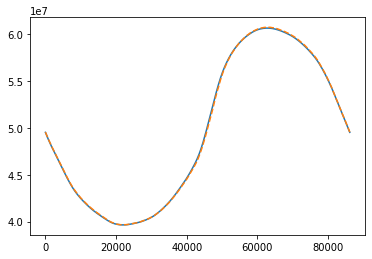

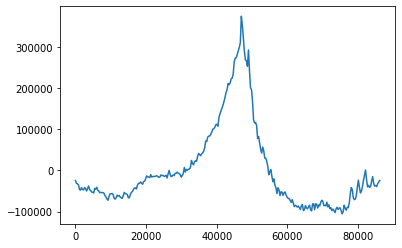

In [619]:
plt.figure()
plt.plot(sim.dt, sim.waterfall[:, 0])
plt.plot(sim.dt, vis_wfall[:, 0] * 1.1787602874958942, ls="--")
plt.show()

plt.figure()
plt.plot(sim.dt, sim.waterfall[:, 0] - 1.1787602874958942 * vis_wfall[:, 0])
plt.show()

# pyuvsim

In [647]:
from hera_sim.visibilities import UVSim

uvsim = VisibilitySimulation(deepcopy(data_model), UVSim(), sky.nside)
_ = uvsim.simulate()

Nbls: 1
Ntimes: 300
Nfreqs: 50
Nsrcs: 49152
Tasks:  15000


UVSim requires time-ordered data. Ensuring that order in UVData...


1.00% completed. 0:00:02.605478  elapsed. 0:04:17.942327 remaining. 

2.00% completed. 0:00:04.960008  elapsed. 0:04:03.040411 remaining. 

3.00% completed. 0:00:07.379158  elapsed. 0:03:58.592784 remaining. 

4.00% completed. 0:00:09.898523  elapsed. 0:03:57.564554 remaining. 

5.00% completed. 0:00:12.496276  elapsed. 0:03:57.429238 remaining. 

6.00% completed. 0:00:16.067963  elapsed. 0:04:11.731422 remaining. 

7.00% completed. 0:00:19.575847  elapsed. 0:04:20.079112 remaining. 

8.00% completed. 0:00:23.074703  elapsed. 0:04:25.359079 remaining. 

9.00% completed. 0:00:26.541018  elapsed. 0:04:28.359187 remaining. 

10.00% completed. 0:00:29.999567  elapsed. 0:04:29.996103 remaining. 

11.00% completed. 0:00:33.454689  elapsed. 0:04:30.678844 remaining. 

12.00% completed. 0:00:36.910774  elapsed. 0:04:30.679009 remaining. 

13.00% completed. 0:00:40.366996  elapsed. 0:04:30.148358 remaining. 

14.00% completed. 0:00:43.801860  elapsed. 0:04:29.068571 remaining. 

15.00% complete

In [656]:
uvsim_wfall = vis_cpu.data_model.uvdata.get_data((0, 0, "xx")).real.copy()
uvsim_wfall *= jy2k  # jy to K
uvsim_wfall *= 2  # 2 pols
uvsim_wfall *= 4*np.pi / sky.npix  # pixel normalization
uvsim_wfall /= sim.beam.total_power  # beam normalization

In [661]:
np.allclose(uvsim_wfall, vis_wfall)

True

# HERA-Sim

In [664]:
from hera_sim import Simulator
hera = Simulator(data=deepcopy(uvd))

In [671]:
hera.add("diffuse_foreground")

You have not specified how to seed the random state. This effect might not be exactly recoverable.


ValueError: A sky temperature model must be specified in order to use this function.